<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/tmp/caox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! pip install imbalanced-learn
#! pip install -U keras-tuner

In [260]:
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from kerastuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Data Preparation

In [86]:
#! git clone https://github.com/Superzchen/iFeature
! python iFeature/iFeature.py --file drive/My\ Drive/sample_test.fasta --type AAC --out AAC.txt

Descriptor type: AAC


In [ ]:
index_df = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/tmp/sample.txt",sep="\t")
cdf = pd.merge(df_c,index_df,on='id')
cdf
#Check Imbalance
#cdf['cat'].value_counts()

#Label Data

In [142]:
df = pd.read_csv("AAC.txt",sep="\t")
df2 = df.rename({'#': 'id'}, axis='columns')
df_02 = pd.DataFrame(df2.id.str.split('|',1).tolist(),columns = ['A','B'])
df_03 = pd.DataFrame(df_02.B.str.split('|',1).tolist(),columns = ['id','B'])
df_c = pd.concat([df_03.iloc[:,0], df.iloc[:,1:21]], axis=1)
cdf = pd.merge(df_c,index_df,on='id')
cdf['cat'].value_counts()

0    143
1     16
Name: cat, dtype: int64

In [277]:
X = cdf.iloc[:,1:21]
Y = cdf.iloc[:,21]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=100)
count_df = pd.DataFrame(y_train) 
count_df['cat'].value_counts()


0    96
1    10
Name: cat, dtype: int64

In [247]:
#split before Sim
X = cdf.iloc[:,1:21]
Y = cdf.iloc[:,21]

X_train_pre, X_test, y_train_pre, y_test = train_test_split(X,Y, test_size=0.30, random_state=100)
#count_df = pd.DataFrame(y_train_pre) 
#count_df['cat'].value_counts()


# Simulate Data
oversample = SMOTE()
X_train_s, y_train_s = oversample.fit_sample(X_train_pre,y_train_pre)




/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Model Reconstruction

In [278]:
def tune_nn_model(hp):
    model = keras.Sequential()
    
    drop_rate = hp.Choice('drop_rate',
                            [
                              0.0,
                              0.1,
                              0.2,
                              0.3,
                              0.4,
                              0.5,
                              0.6,
                              0.7,
                              0.8,
                              0.9
                            ])

     
    model.add(keras.layers.Dense(
      units=28,
      activation="relu",
      input_shape=[X_train.shape[1]]
    ))
    
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(56, activation='relu'))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss = 'binary_crossentropy',
        metrics = ['accuracy',sensitivity, specificity])
    return model

In [280]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='test_dir_2s0gdbsc0',
    project_name='b_tune_nn',
    seed=100
)

In [281]:
b_tuner.search(x=X_train,
             y=y_train,
             epochs=20,
             validation_data=(X_test, y_test))

Epoch 1/20
4/4 [==============================] - 0s 69ms/step - loss: 0.6951 - accuracy: 0.3113 - sensitivity: 0.6042 - specificity: 0.2494 - val_loss: 0.6940 - val_accuracy: 0.3585 - val_sensitivity: 0.5000 - val_specificity: 0.3355
Epoch 2/20
4/4 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.4340 - sensitivity: 0.5417 - specificity: 0.4212 - val_loss: 0.6929 - val_accuracy: 0.6038 - val_sensitivity: 0.5000 - val_specificity: 0.6100
Epoch 3/20
4/4 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.5660 - sensitivity: 0.6500 - specificity: 0.5837 - val_loss: 0.6918 - val_accuracy: 0.7358 - val_sensitivity: 0.2500 - val_specificity: 0.7791
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5094 - sensitivity: 0.5833 - specificity: 0.4779 - val_loss: 0.6907 - val_accuracy: 0.7925 - val_sensitivity: 0.0000e+00 - val_specificity: 0.8938
Epoch 5/20
4/4 [==============================] - 0s 11ms

Epoch 1/20
4/4 [==============================] - 0s 62ms/step - loss: 0.6887 - accuracy: 0.8679 - sensitivity: 0.0500 - specificity: 0.9578 - val_loss: 0.6874 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
4/4 [==============================] - 0s 11ms/step - loss: 0.6876 - accuracy: 0.8868 - sensitivity: 0.0500 - specificity: 0.9578 - val_loss: 0.6864 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
4/4 [==============================] - 0s 10ms/step - loss: 0.6866 - accuracy: 0.8774 - sensitivity: 0.0000e+00 - specificity: 0.9730 - val_loss: 0.6854 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/20
4/4 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.8868 - sensitivity: 0.0000e+00 - specificity: 0.9828 - val_loss: 0.6843 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/20
4/4 [=====================

Epoch 1/20
4/4 [==============================] - 0s 63ms/step - loss: 0.6542 - accuracy: 0.7547 - sensitivity: 0.2917 - specificity: 0.7185 - val_loss: 0.5871 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
4/4 [==============================] - 0s 12ms/step - loss: 0.5729 - accuracy: 0.7736 - sensitivity: 0.0000e+00 - specificity: 0.8613 - val_loss: 0.4934 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
4/4 [==============================] - 0s 10ms/step - loss: 0.5264 - accuracy: 0.8396 - sensitivity: 0.1250 - specificity: 0.9310 - val_loss: 0.4190 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/20
4/4 [==============================] - 0s 10ms/step - loss: 0.5404 - accuracy: 0.8774 - sensitivity: 0.0000e+00 - specificity: 0.9741 - val_loss: 0.3798 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/20
4/4 [====================

Epoch 1/20
4/4 [==============================] - 0s 61ms/step - loss: 0.6749 - accuracy: 0.7075 - sensitivity: 0.0833 - specificity: 0.7292 - val_loss: 0.6183 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
4/4 [==============================] - 0s 12ms/step - loss: 0.5698 - accuracy: 0.8868 - sensitivity: 0.0000e+00 - specificity: 0.9830 - val_loss: 0.5290 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
4/4 [==============================] - 0s 7ms/step - loss: 0.5152 - accuracy: 0.8868 - sensitivity: 0.0000e+00 - specificity: 0.9828 - val_loss: 0.4474 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/20
4/4 [==============================] - 0s 8ms/step - loss: 0.4571 - accuracy: 0.8679 - sensitivity: 0.0000e+00 - specificity: 0.9643 - val_loss: 0.3899 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/20
4/4 [==================

Epoch 1/20
4/4 [==============================] - 0s 62ms/step - loss: 0.6409 - accuracy: 0.9057 - sensitivity: 0.0625 - specificity: 0.9911 - val_loss: 0.5243 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
4/4 [==============================] - 0s 8ms/step - loss: 0.4434 - accuracy: 0.9057 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3664 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 0.3039 - accuracy: 0.9057 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3845 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3507 - accuracy: 0.9057 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.4463 - val_accuracy: 0.8868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/20
4/4 [===================

INFO:tensorflow:Oracle triggered exit


In [282]:
b_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'drop_rate': 0.0, 'learning_rate': 0.0001}

In [283]:
best_model = b_tuner.get_best_models()[0]
history = best_model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.3)

Epoch 1/20
3/3 [==============================] - 0s 80ms/step - loss: 0.6804 - accuracy: 0.9324 - sensitivity: 0.2778 - specificity: 1.0000 - val_loss: 0.6766 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
3/3 [==============================] - 0s 10ms/step - loss: 0.6788 - accuracy: 0.9189 - sensitivity: 0.0667 - specificity: 1.0000 - val_loss: 0.6750 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
3/3 [==============================] - 0s 9ms/step - loss: 0.6771 - accuracy: 0.9189 - sensitivity: 0.1667 - specificity: 1.0000 - val_loss: 0.6733 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/20
3/3 [==============================] - 0s 8ms/step - loss: 0.6754 - accuracy: 0.9054 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.6717 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/20
3/3 [==========================

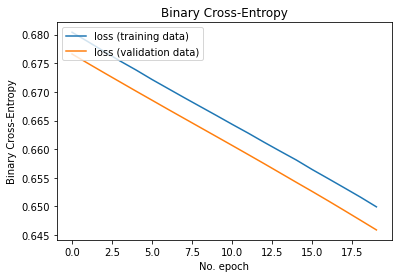

In [285]:
plt.plot(history.history['loss'], label='loss (training data)')
plt.plot(history.history['val_loss'], label='loss (validation data)')
plt.title('Binary Cross-Entropy')
plt.ylabel('Binary Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

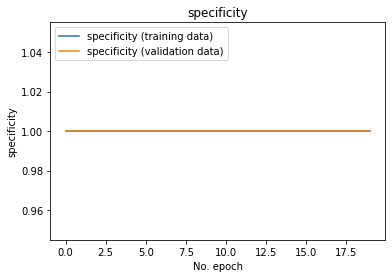

In [286]:
plt.plot(history.history['specificity'], label='specificity (training data)')
plt.plot(history.history['val_specificity'], label='specificity (validation data)')
plt.title('specificity')
plt.ylabel('specificity')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

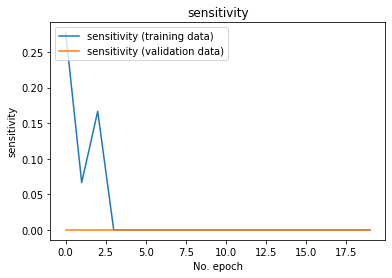

In [287]:
plt.plot(history.history['sensitivity'], label='sensitivity (training data)')
plt.plot(history.history['val_sensitivity'], label='sensitivity (validation data)')
plt.title('sensitivity')
plt.ylabel('sensitivity')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

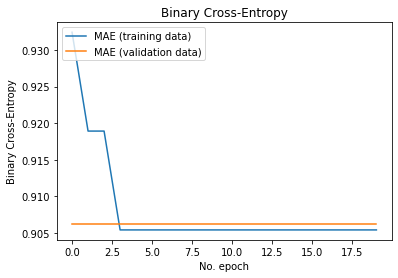

In [288]:
plt.plot(history.history['accuracy'], label='MAE (training data)')
plt.plot(history.history['val_accuracy'], label='MAE (validation data)')
plt.title('Binary Cross-Entropy')
plt.ylabel('Binary Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

In [290]:
from sklearn.metrics import roc_curve
best_model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.3)
y_pred_keras = best_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)


Epoch 1/20
3/3 [==============================] - 0s 25ms/step - loss: 0.6105 - accuracy: 0.9054 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.6059 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
3/3 [==============================] - 0s 9ms/step - loss: 0.6088 - accuracy: 0.9054 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.6041 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
3/3 [==============================] - 0s 8ms/step - loss: 0.6069 - accuracy: 0.9054 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.6020 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/20
3/3 [==============================] - 0s 8ms/step - loss: 0.6047 - accuracy: 0.9054 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.5998 - val_accuracy: 0.9062 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/20
3/3 [===============

In [291]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.6063829787234042

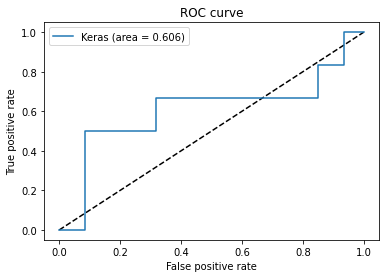

In [292]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()